<a href="https://colab.research.google.com/github/lana994/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Lana_Elgaddafi__assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
df['BUILDING_CLASS_CATEGORY']='01 ONE FAMILY DWELLINGS'
df

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,01 ONE FAMILY DWELLINGS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,01 ONE FAMILY DWELLINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,01 ONE FAMILY DWELLINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,01 ONE FAMILY DWELLINGS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),01 ONE FAMILY DWELLINGS,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23035,4,OTHER,01 ONE FAMILY DWELLINGS,1,10965,276,NaN,A5,111-17 FRANCIS LEWIS BLVD,NaN,11429.0,1.0,0.0,1.0,"1,800",1224.0,1945.0,1,A5,510000,04/30/2019
23036,4,OTHER,01 ONE FAMILY DWELLINGS,2,169,29,NaN,C6,"45-14 43RD STREET, 3C",NaN,11104.0,0.0,0.0,0.0,0,0.0,1929.0,2,C6,355000,04/30/2019
23037,4,OTHER,01 ONE FAMILY DWELLINGS,2,131,4,NaN,D4,"50-05 43RD AVENUE, 3M",NaN,11377.0,0.0,0.0,0.0,0,0.0,1932.0,2,D4,375000,04/30/2019
23038,4,OTHER,01 ONE FAMILY DWELLINGS,1,8932,18,NaN,S2,91-10 JAMAICA AVE,NaN,11421.0,2.0,1.0,3.0,"2,078",2200.0,1931.0,1,S2,1100000,04/30/2019


In [0]:
sale_start=100000
sale_end= 2000000

In [0]:
type(sale_start)

int

In [0]:
df= df[df['SALE_PRICE'] >= sale_start]
df= df[df['SALE_PRICE'] <= sale_end]

In [0]:
df.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [0]:
df= df.fillna(value=0)

In [0]:
df.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
EASE-MENT                         0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
APARTMENT_NUMBER                  0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [0]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,0.0,A9,4832 BAY PARKWAY,0,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,0.0,A1,80-23 232ND STREET,0,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
65,1,OTHER,01 ONE FAMILY DWELLINGS,2,691,1130,0.0,R4,"505 WEST 19TH STREET, 7D",7D,10011.0,1.0,0.0,1.0,"18,975",1077.0,2013.0,2,R4,2000000,01/02/2019
66,1,OTHER,01 ONE FAMILY DWELLINGS,2,1347,18,0.0,D4,"345 EAST 54TH ST, 3B",0,10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4,330000,01/02/2019
67,1,UPPER EAST SIDE (79-96),01 ONE FAMILY DWELLINGS,2,1491,62,0.0,D4,"16 EAST 80TH STREET, 2A",0,10075.0,0.0,0.0,0.0,0,0.0,1925.0,2,D4,600000,01/02/2019


In [0]:
#Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test

In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
cutoff = pd.to_datetime('2019-04-01')


In [0]:
train = df[df.SALE_DATE < cutoff]
test  = df[df.SALE_DATE >= cutoff]

In [0]:
test.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18167,1,OTHER,01 ONE FAMILY DWELLINGS,2,695,1562,0.0,R4,"555 WEST 23RD STREET, N11E",N11E,10011.0,1.0,0.0,1.0,0,670.0,2005.0,2,R4,949000,2019-04-01
18170,1,OTHER,01 ONE FAMILY DWELLINGS,2,721,1008,0.0,R9,"465 WEST 23RD STREET, RCU1",0,10011.0,0.0,0.0,0.0,0,0.0,1932.0,2,R9,1100000,2019-04-01
18173,1,OTHER,01 ONE FAMILY DWELLINGS,2,31,1050,0.0,R4,"75 WALL STREET, 21I",21I,10005.0,1.0,0.0,1.0,0,438.0,1987.0,2,R4,675000,2019-04-01
18174,1,GRAMERCY,01 ONE FAMILY DWELLINGS,2,880,42,0.0,D4,"330 THIRD AVENUE, 18K",0,10010.0,0.0,0.0,0.0,0,0.0,1964.0,2,D4,485000,2019-04-01
18175,1,GRAMERCY,01 ONE FAMILY DWELLINGS,2,878,1010,0.0,R4,"121 EAST 22ND STREET, N204",N204,10010.0,1.0,0.0,1.0,"22,202",773.0,1952.0,2,R4,1486645,2019-04-01


In [0]:
 #Do one-hot encoding of categorical features.
 train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,10488,1,01 ONE FAMILY DWELLINGS,10488,NaT,NaT
BOROUGH,10488,5,4,3627,NaT,NaT
TAX_CLASS_AT_PRESENT,10488,10,1,4964,NaT,NaT
NEIGHBORHOOD,10488,11,OTHER,8876,NaT,NaT
SALE_DATE,10488,80,2019-01-31 00:00:00,287,2019-01-01,2019-03-30
BUILDING_CLASS_AT_PRESENT,10488,96,D4,2118,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,10488,96,D4,2118,NaT,NaT
APARTMENT_NUMBER,10488,828,0,8342,NaT,NaT
LAND_SQUARE_FEET,10488,2005,0,4077,NaT,NaT
ADDRESS,10488,10442,N/A BAY STREET,4,NaT,NaT


In [0]:
train['NEIGHBORHOOD'].value_counts()

OTHER                      8876
FLUSHING-NORTH              310
UPPER EAST SIDE (79-96)     189
UPPER EAST SIDE (59-79)     185
BEDFORD STUYVESANT          182
FOREST HILLS                179
UPPER WEST SIDE (59-79)     140
ASTORIA                     131
UPPER WEST SIDE (79-96)     113
BOROUGH PARK                101
GRAMERCY                     82
Name: NEIGHBORHOOD, dtype: int64

In [0]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].mean()

NEIGHBORHOOD
ASTORIA                    8.392060e+05
BEDFORD STUYVESANT         9.590519e+05
BOROUGH PARK               1.044025e+06
FLUSHING-NORTH             6.911114e+05
FOREST HILLS               5.563429e+05
GRAMERCY                   9.796553e+05
OTHER                      6.841302e+05
UPPER EAST SIDE (59-79)    9.230632e+05
UPPER EAST SIDE (79-96)    8.923332e+05
UPPER WEST SIDE (59-79)    9.455232e+05
UPPER WEST SIDE (79-96)    1.031336e+06
Name: SALE_PRICE, dtype: float64

In [0]:
target = 'SALE_PRICE'
high_cardinality = ['APARTMENT_NUMBER', 'ADDRESS', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_PRESENT','SALE_DATE','BUILDING_CLASS_CATEGORY','ZIP_CODE','BOROUGH','LAND_SQUARE_FEET']
features = train.columns.drop([target] + high_cardinality)

In [0]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [79]:
X_train.head()

,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,OTHER,1,5495,801,0.0,1.0,0.0,1.0,1325.0,1930.0,1
61,OTHER,1,7918,72,0.0,1.0,0.0,1.0,2001.0,1940.0,1
65,OTHER,2,691,1130,0.0,1.0,0.0,1.0,1077.0,2013.0,2
66,OTHER,2,1347,18,0.0,0.0,0.0,0.0,0.0,1960.0,2
67,UPPER EAST SIDE (79-96),2,1491,62,0.0,0.0,0.0,0.0,0.0,1925.0,2


In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [81]:
X_train.head()

,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_UPPER WEST SIDE (79-96),NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_FOREST HILLS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_2,TAX_CLASS_AT_PRESENT_4,TAX_CLASS_AT_PRESENT_2A,TAX_CLASS_AT_PRESENT_1B,TAX_CLASS_AT_PRESENT_1A,TAX_CLASS_AT_PRESENT_2C,TAX_CLASS_AT_PRESENT_1C,TAX_CLASS_AT_PRESENT_2B,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,EASE-MENT,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5495,801,0.0,1.0,0.0,1.0,1325.0,1930.0,1
61,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,7918,72,0.0,1.0,0.0,1.0,2001.0,1940.0,1
65,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,691,1130,0.0,1.0,0.0,1.0,1077.0,2013.0,2
66,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1347,18,0.0,0.0,0.0,0.0,0.0,1960.0,2
67,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1491,62,0.0,0.0,0.0,0.0,0.0,1925.0,2


In [82]:
from sklearn.feature_selection import SelectKBest, f_regression

# SelectKBest has a similar API to what we've seen before.
selector = SelectKBest(score_func=f_regression, k=15);

# IMPORTANT!
# .fit_transform on the train set
# .transform on test set
X_train_selected = selector.fit_transform(X_train, y_train);
X_test_selected = selector.transform(X_test);
X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((10488, 15), (2983, 15))

In [83]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_UPPER WEST SIDE (59-79)
NEIGHBORHOOD_UPPER WEST SIDE (79-96)
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_UPPER EAST SIDE (59-79)
NEIGHBORHOOD_BOROUGH PARK
TAX_CLASS_AT_PRESENT_2
TAX_CLASS_AT_PRESENT_2A
TAX_CLASS_AT_PRESENT_1A
TAX_CLASS_AT_PRESENT_2C
TAX_CLASS_AT_PRESENT_2B
BLOCK
LOT
RESIDENTIAL_UNITS
GROSS_SQUARE_FEET


Features not selected:
NEIGHBORHOOD_UPPER EAST SIDE (79-96)
NEIGHBORHOOD_ASTORIA
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_GRAMERCY
NEIGHBORHOOD_FOREST HILLS
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_4
TAX_CLASS_AT_PRESENT_1B
TAX_CLASS_AT_PRESENT_1C
TAX_CLASS_AT_PRESENT_1D
EASE-MENT
COMMERCIAL_UNITS
TOTAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE


In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $315,776 

2 features
Test MAE: $313,474 

3 features
Test MAE: $311,337 

4 features
Test MAE: $297,982 

5 features
Test MAE: $293,378 

6 features
Test MAE: $293,189 

7 features
Test MAE: $293,026 

8 features
Test MAE: $292,962 

9 features
Test MAE: $292,984 

10 features
Test MAE: $290,487 

11 features
Test MAE: $289,352 

12 features
Test MAE: $288,898 

13 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/p

Test MAE: $289,274 

14 features
Test MAE: $289,350 

15 features
Test MAE: $289,184 

16 features
Test MAE: $289,163 

17 features
Test MAE: $287,804 

18 features
Test MAE: $287,330 

19 features
Test MAE: $286,881 

20 features
Test MAE: $286,815 

21 features
Test MAE: $286,569 

22 features
Test MAE: $286,569 

23 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/p

Test MAE: $286,570 

24 features
Test MAE: $286,492 

25 features
Test MAE: $286,506 

26 features
Test MAE: $286,589 

27 features
Test MAE: $286,589 

28 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/p

Test MAE: $286,806 

29 features
Test MAE: $286,806 

30 features
Test MAE: $286,806 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/p

In [0]:
from IPython.display import display, HTML

In [0]:
import seaborn as sns
anscombe = sns.load_dataset('anscombe').query('dataset=="III"')
anscombe.plot.scatter('x', 'y');

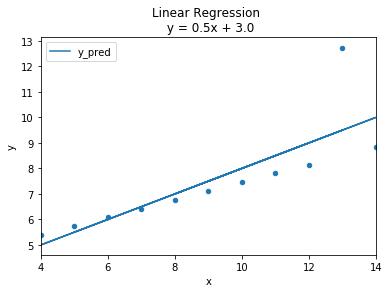

In [97]:
%matplotlib inline

# Plot data
ax = anscombe.plot.scatter('x', 'y')

# Fit linear model
ols = LinearRegression()
ols.fit(anscombe[['x']], anscombe['y'])

# Get linear equation
m = ols.coef_[0].round(2)
b = ols.intercept_.round(2)
title = f'Linear Regression \n y = {m}x + {b}'

# Get predictions
anscombe['y_pred'] = ols.predict(anscombe[['x']])

# Plot predictions
anscombe.plot('x', 'y_pred', ax=ax, title=title);

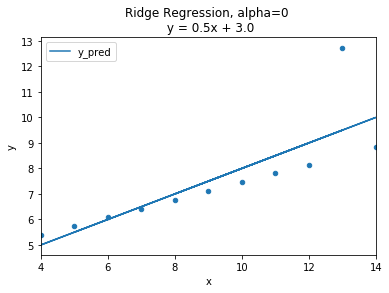

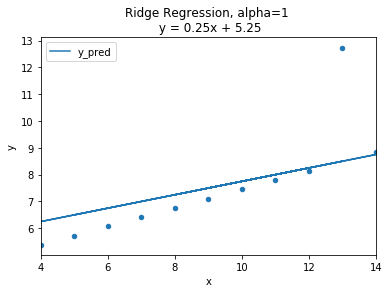

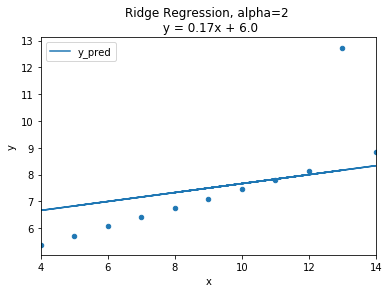

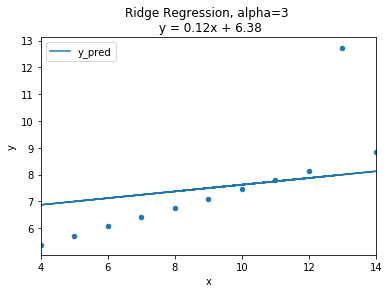

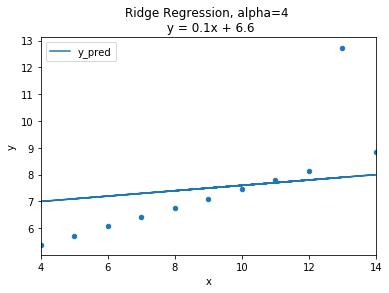

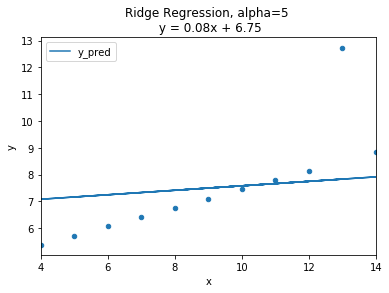

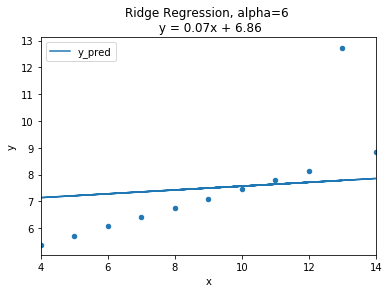

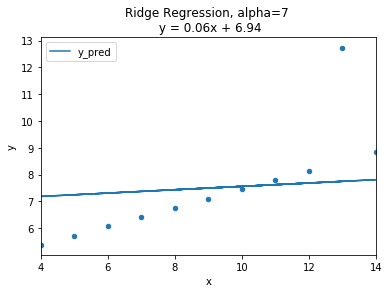

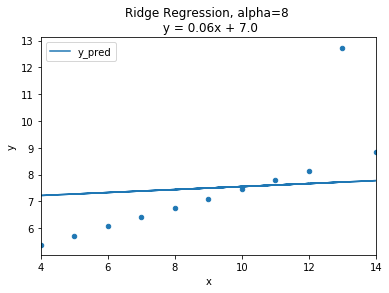

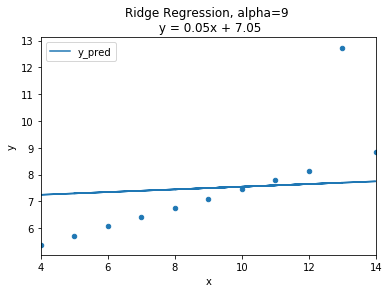

In [98]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

def ridge_anscombe(alpha):
    """
    Fit & plot a ridge regression model,
    with Anscombe Quartet dataset III.

    alpha : positive float, regularization strength
    """

    # Load data
    anscombe = sns.load_dataset('anscombe').query('dataset=="III"')

    # Plot data
    ax = anscombe.plot.scatter('x', 'y')

    # Fit linear model
    ridge = Ridge(alpha=alpha, normalize=True)
    ridge.fit(anscombe[['x']], anscombe['y'])

    # Get linear equation
    m = ridge.coef_[0].round(2)
    b = ridge.intercept_.round(2)
    title = f'Ridge Regression, alpha={alpha} \n y = {m}x + {b}'

    # Get predictions
    anscombe['y_pred'] = ridge.predict(anscombe[['x']])

    # Plot predictions
    anscombe.plot('x', 'y_pred', ax=ax, title=title)
    plt.show()
    
    
for alpha in range(10):
    ridge_anscombe(alpha=alpha)

In [99]:
from sklearn.linear_model import RidgeCV
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge = RidgeCV(alphas=alphas, normalize=True)
ridge.fit(anscombe[['x']], anscombe['y'])
ridge.alpha_

0.1

Test Mean Absolute Error: $286,826


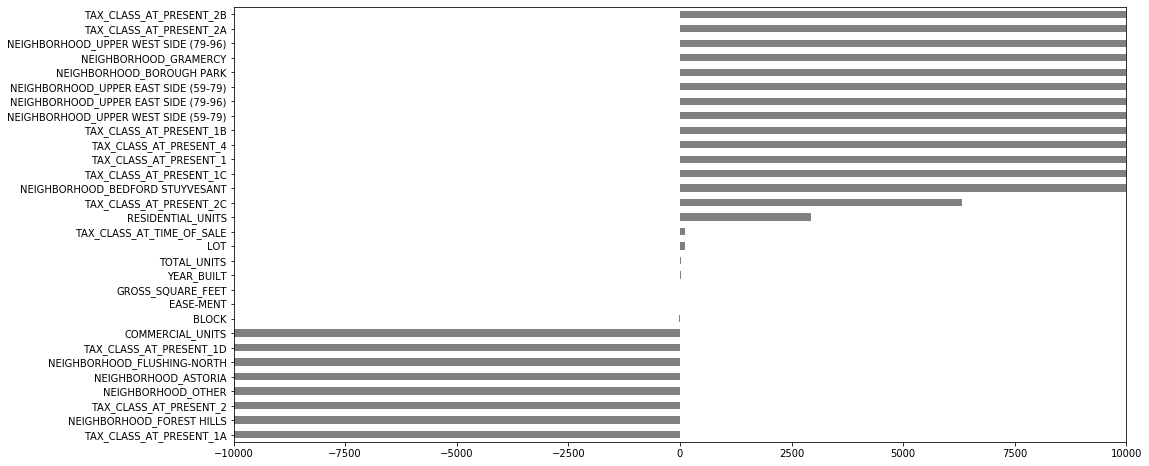

Test Mean Absolute Error: $286,999


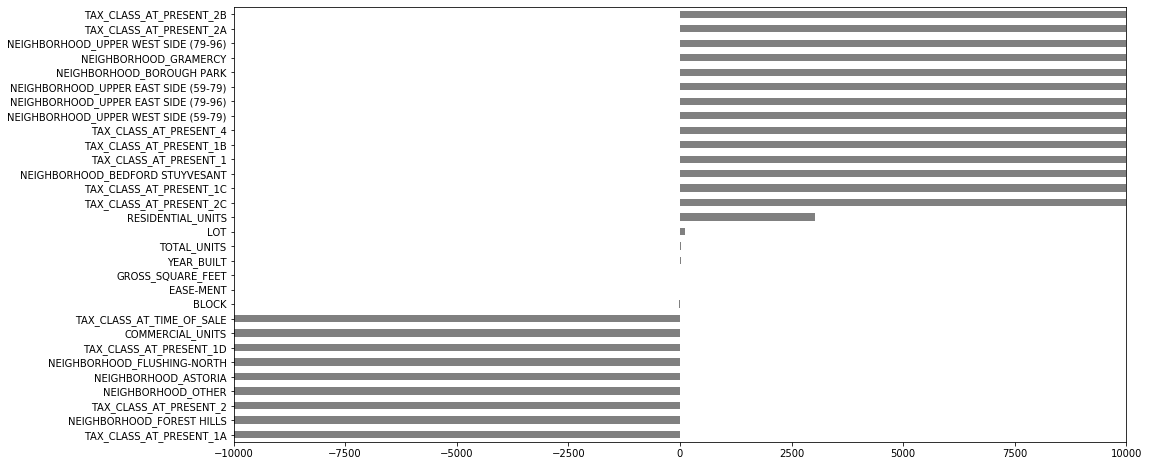

Test Mean Absolute Error: $288,914


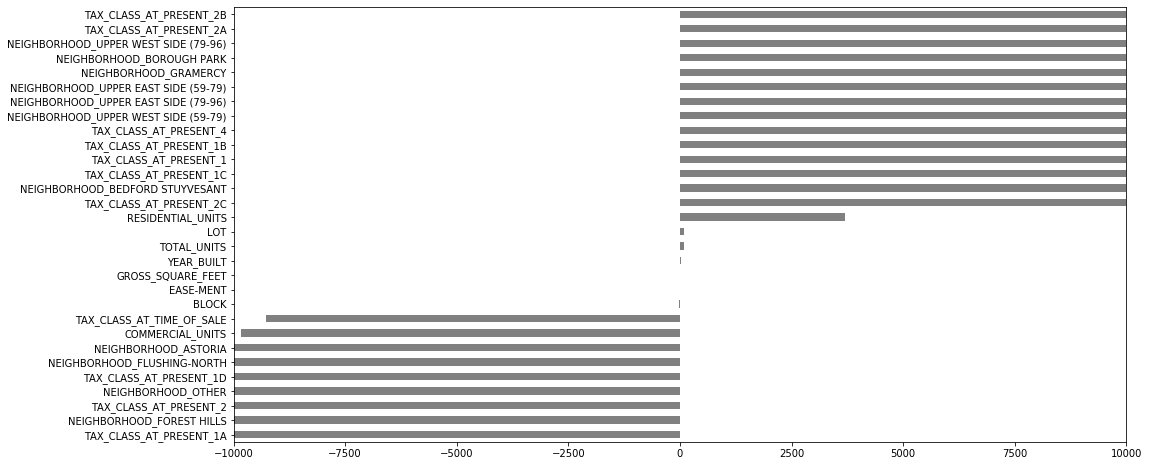

Test Mean Absolute Error: $303,303


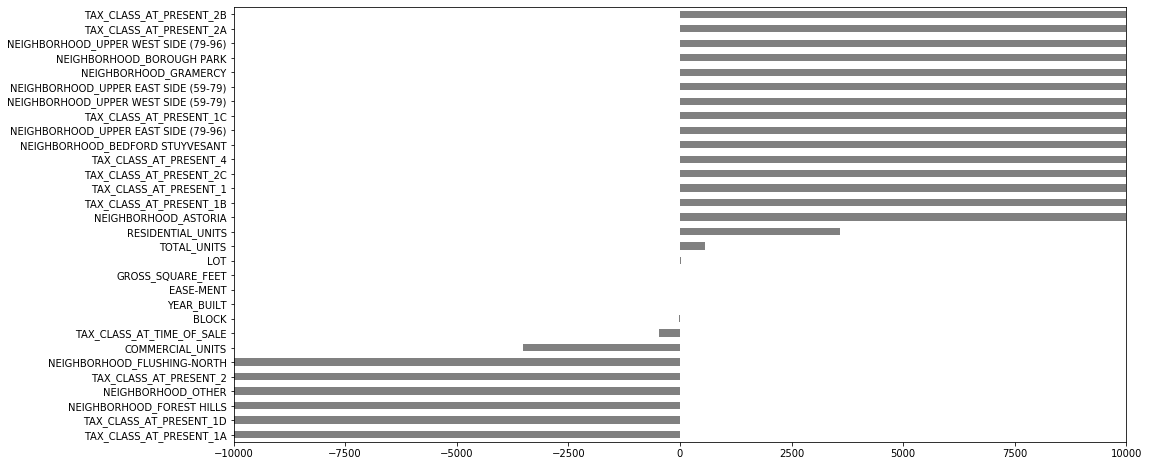

Test Mean Absolute Error: $303,303


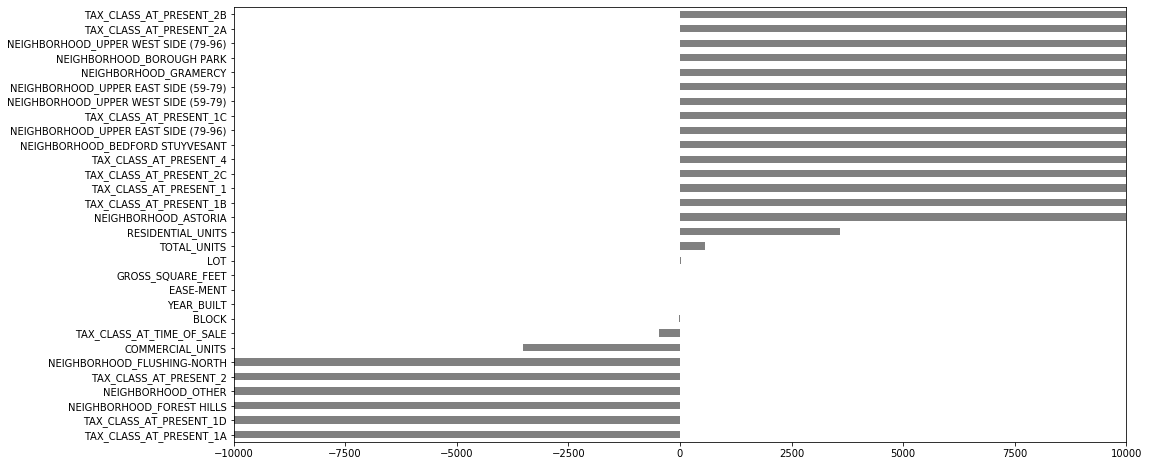

Test Mean Absolute Error: $329,964


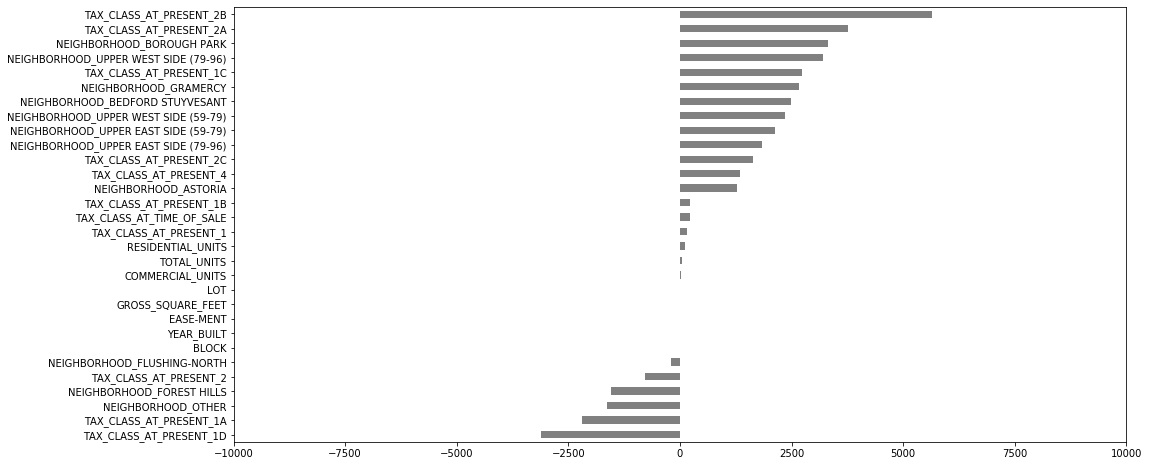

Test Mean Absolute Error: $330,676


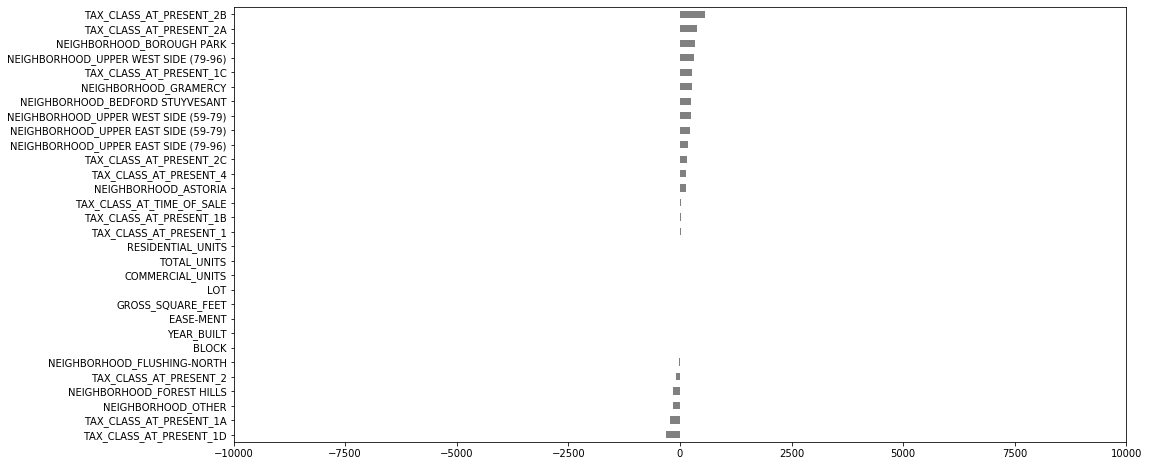

In [101]:
for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    # display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    print(f'Test Mean Absolute Error: ${mae:,.0f}')
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-10000,10000)
    plt.show()